In [1]:
#nativos
import os
import unicodedata

#terceros
import pandas as pd
import pymssql
import missingno as msno
from collections import Counter

#grafico
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline
sns.set(style="whitegrid")

#propios
from utils_ficha import *
from querys import *

C:\Users\B38381\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  import sys


In [2]:
#conneciom B20
connection_b20 = pymssql.connect(host='10.10.33.92\SQL2008',
                             user='userweb',
                             port=1433,
                             password='$$W3BVPC2@17',
                             database='WEBVPC'
                            )

In [3]:
#conneciom MARKET
connection_market = pymssql.connect(host='10.11.12.90\BDT',
                             user='ibetlmarket',
                             port=1433,
                             password='m@rk3t2o15',
                             database='MARKET'
                            )

## OBTENCIÓN DE UNIVERSO

In [4]:
query_base_be = """
SELECT * FROM STG.HD_VMVP_BASE_ALERTA_CARTERA_BE
"""
data_market_be = pd.read_sql(
   query_base_be , connection_market
).rename(
    columns={'FECHA_ACTUALIZACION': 'FECHA_ACTUALIZACION_MARKET'}
)
data_market_be.head(3)

,TIPDOC,CODDOC,FECHA_ACTUALIZACION_MARKET,CODUNICOCLI,NOMBRE_COMPLETO,DES_GRUPO_ECONOMICO,RIESGO,ENCARGADO,NOMBRE_JEFE,ESTADO,...,FUNNEL_3,FUNNEL_4,FLG_VIGENTE,FLG_SUSPENDIDO,FLG_VENCIDA,FLG_CANCELADO,FLG_MONOLINEA,FLG_SOLO_REACTIVA,FLG_POSICION,CLASIFICACION_LIST_360
0,2,20537451484,2020-10-27 13:00:56.210,0011978079,INTEGRAL SOLUTIONS IN ENGINEERING,INTSEN,545672.682257,RAQUEL IRENE CORDOVA ZAMORA,JAVIER GONZALES VELARDE,VALIDADO,...,1,1,0,0,0,0,0,0,1,None
1,2,20477758844,2020-10-27 13:00:56.210,0011281436,REYCH CONTRATISTAS GENERALES,,82265.765714,AISSA LIZBETH TRONCOS RIOFRIO,ROBERTO CARLOS PALACIOS PANDO,SIN SEGUIMIENTO,...,1,1,0,0,0,0,0,0,1,None
2,2,20520775596,2020-10-27 13:00:56.210,0010975562,SATELCOM PERU,,26710.548571,CRISTINA DIAZ QUISPE,MIRANDA ZAMBRANO JORGE ALFREDO,SIN SEGUIMIENTO,...,1,1,0,0,0,0,0,0,1,None


##### Cantidad de clientes objetivos

In [5]:
data_market_be.shape[0]

834

#### Variables disponibles de primera mano

In [6]:
data_market_be.columns

Index(['TIPDOC', 'CODDOC', 'FECHA_ACTUALIZACION_MARKET', 'CODUNICOCLI',
       'NOMBRE_COMPLETO', 'DES_GRUPO_ECONOMICO', 'RIESGO', 'ENCARGADO',
       'NOMBRE_JEFE', 'ESTADO', 'BUCKET', 'PREOCUPA', 'REGISTRO',
       'FECHA_LLENADO', 'USUARIO_NOTIFICADO', 'REVISION_USUARIO',
       'FECHA_APROBACION', 'IMPACTO', 'PLAN_PROPUESTO', 'MONTO_CRECER',
       'DETALLE_CRECER', 'FEVE', 'BLINDAJE', 'MESES_BLINDAJE', 'COMENTARIOS',
       'COMENTARIO_ROL_VALIDADOR', 'FUNNEL_1', 'FUNNEL_2', 'FUNNEL_3',
       'FUNNEL_4', 'FLG_VIGENTE', 'FLG_SUSPENDIDO', 'FLG_VENCIDA',
       'FLG_CANCELADO', 'FLG_MONOLINEA', 'FLG_SOLO_REACTIVA', 'FLG_POSICION',
       'CLASIFICACION_LIST_360'],
      dtype='object')

#### Visualización de estados de fichas 

In [7]:
data_market_be['ESTADO'].value_counts(dropna=False)

VALIDADO           419
SIN SEGUIMIENTO    276
LLENADO             87
CON CONOCEME        52
Name: ESTADO, dtype: int64

#### Nos quedamos con los clientes con fichas en estado "LLENADO" y "VALIDADO"

In [8]:
data_market_be = data_market_be[data_market_be['ESTADO'].isin(['VALIDADO', 'LLENADO'])]
data_market_be.shape

(506, 38)

In [9]:
print(list(data_market_be.columns))

['TIPDOC', 'CODDOC', 'FECHA_ACTUALIZACION_MARKET', 'CODUNICOCLI', 'NOMBRE_COMPLETO', 'DES_GRUPO_ECONOMICO', 'RIESGO', 'ENCARGADO', 'NOMBRE_JEFE', 'ESTADO', 'BUCKET', 'PREOCUPA', 'REGISTRO', 'FECHA_LLENADO', 'USUARIO_NOTIFICADO', 'REVISION_USUARIO', 'FECHA_APROBACION', 'IMPACTO', 'PLAN_PROPUESTO', 'MONTO_CRECER', 'DETALLE_CRECER', 'FEVE', 'BLINDAJE', 'MESES_BLINDAJE', 'COMENTARIOS', 'COMENTARIO_ROL_VALIDADOR', 'FUNNEL_1', 'FUNNEL_2', 'FUNNEL_3', 'FUNNEL_4', 'FLG_VIGENTE', 'FLG_SUSPENDIDO', 'FLG_VENCIDA', 'FLG_CANCELADO', 'FLG_MONOLINEA', 'FLG_SOLO_REACTIVA', 'FLG_POSICION', 'CLASIFICACION_LIST_360']


In [10]:
data_market_be['FEVE'] = data_market_be['FEVE'].fillna('Sin categoria')
data_market_be['FEVE'].value_counts(dropna=False)

Sin FEVE         286
Seguir COVID      85
Seguir            75
Reducir           25
Sin categoria     21
Garantizar         9
Salir              5
Name: FEVE, dtype: int64

In [11]:
data_market_be.shape, data_market_be['CODUNICOCLI'].unique().shape

((506, 38), (506,))

In [12]:
query_sow = """
    SELECT * FROM STG.HD_VMVP_SOW_ALERTA_CARTERA_BE
    ORDER BY COD_UNICO, PERIODO DESC
"""

sow = pd.read_sql(
   query_sow , connection_market
)

sow.groupby(by=['PERIODO']).size()

PERIODO
201903    780
201904    779
201905    784
201906    782
201907    784
201908    786
201909    796
201910    802
201911    806
201912    805
202001    814
202002    816
202003    820
202004    818
202005    825
202006    827
202007    831
202008    829
202009    830
dtype: int64

## REACTIVA IBK

In [13]:
query_reactiva_ibk = """
SELECT A.PERIODO, A.CODUNICOCLI CODUNICOCLI_R2, B.NUM_DOC, B.NRO_CREDITO,B.RAZON_SOCIAL, B.UBIGEO, B.CIIU, B.NRO_TRABAJADORES,
       A.IMPORTE, B.MONTO_PRESTAMO  MONTO_PRESTAMO_REACTIVA_2, B.FLG_TOMO_REACTIVA_1, B.MONTO_PRESTAMO_REACTIVA_1, 
       B.MONTO_VENTA_ANUAL, B.MONTO_EXPORTACION, B.APORTE_ESSALUD_2019, B.VENTA_PROMEDIO,
	   CASE WHEN CERTIFICADO like 'CGAR2-%' THEN 2
	       WHEN CERTIFICADO like 'CGAR-%' THEN 1
		   ELSE 0 END TIPO_REACTIVA_COFIDE
FROM 
ODS.MD_DESEMBOLSO_REACTIVA A WITH (NOLOCK)
LEFT JOIN
ODS.HD_ENVIO_COFIDE_V B WITH (NOLOCK)
on A.CODUNICOCLI = B.CODUNICOCLI and A.NRO_CREDITO = B.NRO_CREDITO
WHERE 1 = 1
and B.ESTADO = 'ENVIADO'
and CERTIFICADO like 'CGAR2-%'
ORDER BY B.RAZON_SOCIAL DESC
"""

#reactiva_ibk = pd.read_sql(
#   query_reactiva_ibk , connection_market
#)
#reactiva_ibk.head(2)

In [14]:
#reactiva_ibk.shape,  reactiva_ibk['CODUNICOCLI_R2'].unique().shape

In [15]:
#reactiva_ibk = reactiva_ibk.drop_duplicates()
#reactiva_ibk.shape,  reactiva_ibk['CODUNICOCLI_R2'].unique().shape

In [16]:
#dd = reactiva_ibk.groupby(by=['CODUNICOCLI_R2']).size()
#dd[dd > 1]

In [17]:
#reactiva_ibk = reactiva_ibk[
#    ~(reactiva_ibk['CODUNICOCLI_R2'] == '0000050088') | ~(reactiva_ibk['APORTE_ESSALUD_2019'].isnull())
#]
#reactiva_ibk.shape,  reactiva_ibk['CODUNICOCLI_R2'].unique().shape

#### Columnas Reactiva IBK

In [18]:
#print(list(reactiva_ibk.columns))

In [19]:
#reactiva_ibk.columns = [
#    'IBK_R2_' + col if (col != 'CODUNICOCLI_R2') else col for col in reactiva_ibk.columns
#]

#print(list(reactiva_ibk.columns))

In [20]:
#reactiva_ibk.shape

### Unificando fuente

In [21]:
#data_market_be = data_market_be.merge(
#    reactiva_ibk, how='left', left_on='CODUNICOCLI', right_on='CODUNICOCLI_R2'
#)
#data_market_be.shape[0]

In [22]:
data_market_be.shape

(506, 38)

## REVISION DE GARANTIAS

In [23]:
query_garantias_por_tipo_entidad = """
SELECT * FROM
(
	SELECT COD_UNICO, 
	CASE WHEN TIP_EMPRESA LIKE 'CAJA%' THEN 'CAJAS' 
	     ELSE TIP_EMPRESA END TIPO_EMPRESA,
	     MTO_DEUDA
	FROM ODS.HM_SALDO_RCC
	WHERE 1 = 1
	--and NUM_DOC LIKE '%%' 
	and PERIODO = (SELECT MAX(PERIODO) FROM ODS.HM_SALDO_RCC)
	--and SITUACION IS NULL 
	and TIPO_PRODUCTO LIKE 'GARANTIA%'
	and TIPO_PRODUCTO NOT LIKE '%REACTIVA%'
	and COD_UNICO IS NOT NULL
	and COD_STATUS_EMPRESA = 'EN OPERACION'
	and NBR_EMPRESA != 'BANCO INTERNACIONAL DEL PERU'
	and COD_UNICO IN (SELECT CODUNICOCLI FROM STG.HD_VMVP_BASE_ALERTA_CARTERA_BE WHERE ESTADO IN ('LLENADO', 'VALIDADO'))
	--ORDER BY COD_UNICO DESC
) A
where A.TIPO_EMPRESA IN ('BANCOS', 'FINANCIERAS', 'CAJAS')
"""
#garantia = pd.read_sql(
#   query_garantias_por_tipo_entidad , connection_market
#)
#garantia.head(2)

In [24]:
#garantia = pd.pivot_table(
#    garantia, 
#    values='MTO_DEUDA',  
#    index='COD_UNICO', 
#    columns=['TIPO_EMPRESA'],
#    aggfunc=sum
#).reset_index()

#garantia.head(3)

In [25]:
#garantia.columns = ['TOTAL_GARANTIAS_NO_IBK_'+ col if col != 'COD_UNICO' else col for col in garantia.columns ]
#garantia.head()

## CEF

In [26]:
#query_cef_situacion = """
#    SELECT * FROM PC_CEF_SITUACION 
#    WHERE FECPROCESO like '2019-12%'
#    ORDER BY COD_UNICO DESC , DESTIPESTADOFINANCIERO DESC
#"""
#cef = pd.read_sql(
#   query_cef_situacion , connection_market
#)
#cef.head(2)

## CARGA DE FICHA CONOCEME

In [27]:
query_conoceme = """
    SELECT * FROM WEBBE_INFINITY_CONOCEME ORDER BY FECHA_ACTUALIZACION DESC
"""
conoceme = pd.read_sql(
   query_conoceme , connection_b20
)
conoceme.head(2)

,COD_UNICO,ACTIVIDAD,SUBSECTOR,BACKLOG,MODELO_NEGOCIO,VENTAJA_COMPETITIVA,FORTALEZAS_RIESGOS,INTEGRACION_VERTICAL,GESTION_COMPRAS,REGISTRO,...,PROYECCION_INVERSION,PROYECCION_VENTAS,FECHA_ACTUALIZACION,PROCEDENCIA_MPRIMA,LINEA_SUCESION_FLAG,LINEA_SUCESION,CAMBIO_GERENCIA_GENERAL_ANNIO,CAMBIO_ACCIONISTAS_ANNIO,INICIO_IBK,INICIO_OP
0,0010545047,Servicios,Metalmecánica,Proyectos,"La empresa brinda servicios de proyectos, inge...",Brinda un servicio diferenciado desde la ingen...,Fortalezas:\r\n- Cartera de clientes de buen c...,None,None,B30434,...,NaN,NaN,2020-11-09 00:00:00,None,0,0,NaN,NaN,2019.0,2006.0
1,0015013920,Servicios,Servicios diversos,No Aplica,Empresa internacional pionera y especialista e...,Experiencia internacional en el sector en el q...,F: Importante cartera de clientes.\r\nR: Cambi...,None,None,B37708,...,NaN,NaN,2020-10-27 21:49:13,Exterior,0,None,NaN,NaN,2017.0,2017.0


#### Fichas conoceme disponibles en total

In [28]:
conoceme.shape[0]

987

#### Obtencón de fichas conoceme de universo fijo

In [29]:
conoceme = data_market_be.merge(
    conoceme, how='left', left_on='CODUNICOCLI', right_on='COD_UNICO'
)
conoceme.shape[0]

508

#### Columnas disponibles en FICHA CONOCEME

In [30]:
print(list(conoceme.columns))

['TIPDOC', 'CODDOC', 'FECHA_ACTUALIZACION_MARKET', 'CODUNICOCLI', 'NOMBRE_COMPLETO', 'DES_GRUPO_ECONOMICO', 'RIESGO', 'ENCARGADO', 'NOMBRE_JEFE', 'ESTADO', 'BUCKET', 'PREOCUPA', 'REGISTRO_x', 'FECHA_LLENADO', 'USUARIO_NOTIFICADO', 'REVISION_USUARIO', 'FECHA_APROBACION', 'IMPACTO', 'PLAN_PROPUESTO', 'MONTO_CRECER', 'DETALLE_CRECER', 'FEVE', 'BLINDAJE', 'MESES_BLINDAJE', 'COMENTARIOS', 'COMENTARIO_ROL_VALIDADOR', 'FUNNEL_1', 'FUNNEL_2', 'FUNNEL_3', 'FUNNEL_4', 'FLG_VIGENTE', 'FLG_SUSPENDIDO', 'FLG_VENCIDA', 'FLG_CANCELADO', 'FLG_MONOLINEA', 'FLG_SOLO_REACTIVA', 'FLG_POSICION', 'CLASIFICACION_LIST_360', 'COD_UNICO', 'ACTIVIDAD', 'SUBSECTOR', 'BACKLOG', 'MODELO_NEGOCIO', 'VENTAJA_COMPETITIVA', 'FORTALEZAS_RIESGOS', 'INTEGRACION_VERTICAL', 'GESTION_COMPRAS', 'REGISTRO_y', 'GERENTE_GENERAL', 'GERENTE_FINANCIERO_TIPO', 'GERENTE_FINANCIERO_NOMBRE', 'TIPO_CONTABILIDAD', 'MONTO_LINEA_PROVEEDORES', 'ACTIVO_LIBRE_GRAVAMEN', 'PROYECCION_INVERSION', 'PROYECCION_VENTAS', 'FECHA_ACTUALIZACION', 'PROCE

#### Eliminamos registros mas antiguas que contengan informacion del mismo COD_UNICO

In [31]:
print("ANTES con duplicados: ", conoceme.shape[0])
conoceme = conoceme.drop_duplicates(subset=['COD_UNICO'], keep='first')
print("Regsistros unicos por codigo único: ", conoceme.shape[0])

ANTES con duplicados:  508
Regsistros unicos por codigo único:  506


## CARGA FICHA COVID

In [32]:
query_covid = """
    SELECT * FROM WEBVPC_COVID19 ORDER BY FECHA_CREACION DESC
"""
covid = pd.read_sql(
   query_covid , connection_b20
)
covid.head(2)

,ID,ID_VISITA,COD_UNICO,FECHA_REGISTRO,PREGUNTA_1,PREGUNTA_2_1,PREGUNTA_2_2,PREGUNTA_2_3_1,PREGUNTA_2_3_2,PREGUNTA_3,...,FECHA_CREACION,USUARIO_MODIFICACION,FECHA_MODIFICACION,MONTO_CRECER,DETALLE_CRECER,FECHA_APROBACION,USUARIO_GYS,USUARIO_ADMISION,USUARIO_NOTIFICADO,USUARIO_ACOMP
0,848,1080,0015435251,2020-10-27,1,1,2,1,25.0,El cliente refinanció deuda con IBK por USD 60...,...,2020-10-27,None,NaT,NaN,None,NaT,None,None,B12687,None
1,851,1083,0013597301,2020-10-26,1,1,1,2,NaN,La empresa implementó protocolos de seguridad ...,...,2020-10-27,None,NaT,1000.0,CF y Descuento Electrónico,NaT,None,None,B31820,None


#### Estandarización de columnas a tratar

In [33]:
print(list(covid.columns))

['ID', 'ID_VISITA', 'COD_UNICO', 'FECHA_REGISTRO', 'PREGUNTA_1', 'PREGUNTA_2_1', 'PREGUNTA_2_2', 'PREGUNTA_2_3_1', 'PREGUNTA_2_3_2', 'PREGUNTA_3', 'PREGUNTA_4', 'PREGUNTA_5_1', 'PREGUNTA_5_2', 'PREGUNTA_6_1', 'PREGUNTA_6_2', 'PREGUNTA_7', 'PREGUNTA_7_1', 'PREGUNTA_7_2_1', 'PREGUNTA_7_2_2', 'PREGUNTA_7_3', 'PREGUNTA_7_4', 'PREGUNTA_8_1', 'PREGUNTA_8_1_1_1', 'PREGUNTA_8_1_1_2', 'PREGUNTA_8_1_2', 'PREGUNTA_8_2', 'PREGUNTA_8_3', 'PREGUNTA_8_3_2', 'PREGUNTA_8_3_1', 'PREGUNTA_9_1', 'PREGUNTA_9_2', 'PREGUNTA_10_1', 'PREGUNTA_10_2', 'PREGUNTA_11', 'PREGUNTA_11_1_1', 'PREGUNTA_11_1_2', 'PREGUNTA_11_2_1', 'PREGUNTA_11_2_2', 'PREGUNTA_11_3_1', 'PREGUNTA_11_3_2', 'PREGUNTA_11_4_1', 'PREGUNTA_11_4_2', 'PREGUNTA_11_5_1', 'PREGUNTA_11_5_2', 'PREGUNTA_11_6_1', 'PREGUNTA_11_6_2', 'PREGUNTA_12', 'PREGUNTA_12_1', 'PREGUNTA_12_2', 'PREGUNTA_12_2_1', 'PREGUNTA_12_2_2_1', 'PREGUNTA_12_2_2_2', 'PREGUNTA_13', 'PREGUNTA_14_1', 'PREGUNTA_14_2', 'PREGUNTA_14_3', 'PREGUNTA_14_4', 'PREGUNTA_14_5', 'ESTADO_APROBACI

In [34]:
covid.columns = [col.replace('PREGUNTA', 'COVID_P') for col in covid.columns]
print(list(covid.columns))

['ID', 'ID_VISITA', 'COD_UNICO', 'FECHA_REGISTRO', 'COVID_P_1', 'COVID_P_2_1', 'COVID_P_2_2', 'COVID_P_2_3_1', 'COVID_P_2_3_2', 'COVID_P_3', 'COVID_P_4', 'COVID_P_5_1', 'COVID_P_5_2', 'COVID_P_6_1', 'COVID_P_6_2', 'COVID_P_7', 'COVID_P_7_1', 'COVID_P_7_2_1', 'COVID_P_7_2_2', 'COVID_P_7_3', 'COVID_P_7_4', 'COVID_P_8_1', 'COVID_P_8_1_1_1', 'COVID_P_8_1_1_2', 'COVID_P_8_1_2', 'COVID_P_8_2', 'COVID_P_8_3', 'COVID_P_8_3_2', 'COVID_P_8_3_1', 'COVID_P_9_1', 'COVID_P_9_2', 'COVID_P_10_1', 'COVID_P_10_2', 'COVID_P_11', 'COVID_P_11_1_1', 'COVID_P_11_1_2', 'COVID_P_11_2_1', 'COVID_P_11_2_2', 'COVID_P_11_3_1', 'COVID_P_11_3_2', 'COVID_P_11_4_1', 'COVID_P_11_4_2', 'COVID_P_11_5_1', 'COVID_P_11_5_2', 'COVID_P_11_6_1', 'COVID_P_11_6_2', 'COVID_P_12', 'COVID_P_12_1', 'COVID_P_12_2', 'COVID_P_12_2_1', 'COVID_P_12_2_2_1', 'COVID_P_12_2_2_2', 'COVID_P_13', 'COVID_P_14_1', 'COVID_P_14_2', 'COVID_P_14_3', 'COVID_P_14_4', 'COVID_P_14_5', 'ESTADO_APROBACION', 'ESTADO_REGISTRO', 'USUARIO_CREACION', 'FECHA_CRE

In [35]:
covid.columns = ['COVID_' + col if (col != 'COD_UNICO' and not col.startswith('COVID')) else col for col in covid.columns]
print(list(covid.columns))

['COVID_ID', 'COVID_ID_VISITA', 'COD_UNICO', 'COVID_FECHA_REGISTRO', 'COVID_P_1', 'COVID_P_2_1', 'COVID_P_2_2', 'COVID_P_2_3_1', 'COVID_P_2_3_2', 'COVID_P_3', 'COVID_P_4', 'COVID_P_5_1', 'COVID_P_5_2', 'COVID_P_6_1', 'COVID_P_6_2', 'COVID_P_7', 'COVID_P_7_1', 'COVID_P_7_2_1', 'COVID_P_7_2_2', 'COVID_P_7_3', 'COVID_P_7_4', 'COVID_P_8_1', 'COVID_P_8_1_1_1', 'COVID_P_8_1_1_2', 'COVID_P_8_1_2', 'COVID_P_8_2', 'COVID_P_8_3', 'COVID_P_8_3_2', 'COVID_P_8_3_1', 'COVID_P_9_1', 'COVID_P_9_2', 'COVID_P_10_1', 'COVID_P_10_2', 'COVID_P_11', 'COVID_P_11_1_1', 'COVID_P_11_1_2', 'COVID_P_11_2_1', 'COVID_P_11_2_2', 'COVID_P_11_3_1', 'COVID_P_11_3_2', 'COVID_P_11_4_1', 'COVID_P_11_4_2', 'COVID_P_11_5_1', 'COVID_P_11_5_2', 'COVID_P_11_6_1', 'COVID_P_11_6_2', 'COVID_P_12', 'COVID_P_12_1', 'COVID_P_12_2', 'COVID_P_12_2_1', 'COVID_P_12_2_2_1', 'COVID_P_12_2_2_2', 'COVID_P_13', 'COVID_P_14_1', 'COVID_P_14_2', 'COVID_P_14_3', 'COVID_P_14_4', 'COVID_P_14_5', 'COVID_ESTADO_APROBACION', 'COVID_ESTADO_REGISTRO', 

#### Eliminamos registros mas antiguas que contengan informacion del mismo COD_UNICO

In [36]:
print("ANTES con duplicados: ", covid.shape[0])
covid = covid.drop_duplicates(subset=['COD_UNICO'], keep='first')
print("Regsistros únicos por codigo único: ", covid.shape[0])

ANTES con duplicados:  827
Regsistros únicos por codigo único:  796


#### Unificamos fuentes

In [37]:
conoceme = conoceme.merge(
    covid, how='left', left_on='CODUNICOCLI', right_on='COD_UNICO'
)
conoceme.shape

(506, 135)

In [38]:
del covid
del data_market_be

## CARGA FICHA VISITAME

In [39]:
query_visitame = """
    SELECT * FROM Webbe_infinity_visita ORDER BY FECHA_VISITA DESC
"""
visitame = pd.read_sql(
   query_visitame , connection_b20
)
visitame.head(2)

,ID,COD_UNICO,FLG_CAMBIO_MIX_VENTAS,FLG_CAMBIO_PROCESO_INTEGRACION,FLG_CAMBIO_CONCENTRACION_VENTAS,FLG_CAMBIO_CONCENTRACION_PROVEEDORES,FLG_CAMBIO_OPERACIONES,FLG_CAMBIO_ZONA_CLIENTES,FLG_CAMBIO_GERENCIA_GENERAL,FLG_CAMBIO_GESTION_FINANCIERA,...,FLG_CAMBIO_PRESTAMO_DESVIO,FLG_CAMBIO_BACKLOG,REVISION_FECHA,REVISION_USUARIO,FLG_CAMBIO_MODELO_NEGOCIO,CAMBIO_PRESTAMO_DESVIO,CAMBIO_INVERSION_ACTIVO_PATRIMONIO,FLG_PROCESO,FECHA_PROCESO,COMENTARIO_ROL_VALIDADOR
0,880,0010545047,0,0,0,0,0,0,0,0,...,0,0,2020-09-28 15:49:04,B14255,0,None,None,NaN,NaT,"Conforme, a pesar de la Pandemia cliente ha ce..."
1,1080,0015435251,0,0,0,0,0,0,0,0,...,0,0,NaT,None,0,None,None,NaN,NaT,None


#### Estandarización de columnas a tratar

In [40]:
print(list(visitame.columns))

['ID', 'COD_UNICO', 'FLG_CAMBIO_MIX_VENTAS', 'FLG_CAMBIO_PROCESO_INTEGRACION', 'FLG_CAMBIO_CONCENTRACION_VENTAS', 'FLG_CAMBIO_CONCENTRACION_PROVEEDORES', 'FLG_CAMBIO_OPERACIONES', 'FLG_CAMBIO_ZONA_CLIENTES', 'FLG_CAMBIO_GERENCIA_GENERAL', 'FLG_CAMBIO_GESTION_FINANCIERA', 'FLG_CAMBIO_ACCIONISTAS', 'FLG_CAMBIO_LINEAS', 'REGISTRO', 'ENTREVISTADO_CARGO', 'ENTREVISTADO_NOMBRE', 'COMENTARIOS', 'FECHA_VISITA', 'FECHA_REGISTRO', 'FLG_CAMBIO_INVERSION_ACTIVO_PATRIMONIO', 'FLG_CAMBIO_PRESTAMO_DESVIO', 'FLG_CAMBIO_BACKLOG', 'REVISION_FECHA', 'REVISION_USUARIO', 'FLG_CAMBIO_MODELO_NEGOCIO', 'CAMBIO_PRESTAMO_DESVIO', 'CAMBIO_INVERSION_ACTIVO_PATRIMONIO', 'FLG_PROCESO', 'FECHA_PROCESO', 'COMENTARIO_ROL_VALIDADOR']


In [41]:
visitame.columns = ['VISITAME_' + col if (col != 'COD_UNICO' and not col.startswith('FLG_')) else col for col in visitame.columns]
print(list(visitame.columns))

['VISITAME_ID', 'COD_UNICO', 'FLG_CAMBIO_MIX_VENTAS', 'FLG_CAMBIO_PROCESO_INTEGRACION', 'FLG_CAMBIO_CONCENTRACION_VENTAS', 'FLG_CAMBIO_CONCENTRACION_PROVEEDORES', 'FLG_CAMBIO_OPERACIONES', 'FLG_CAMBIO_ZONA_CLIENTES', 'FLG_CAMBIO_GERENCIA_GENERAL', 'FLG_CAMBIO_GESTION_FINANCIERA', 'FLG_CAMBIO_ACCIONISTAS', 'FLG_CAMBIO_LINEAS', 'VISITAME_REGISTRO', 'VISITAME_ENTREVISTADO_CARGO', 'VISITAME_ENTREVISTADO_NOMBRE', 'VISITAME_COMENTARIOS', 'VISITAME_FECHA_VISITA', 'VISITAME_FECHA_REGISTRO', 'FLG_CAMBIO_INVERSION_ACTIVO_PATRIMONIO', 'FLG_CAMBIO_PRESTAMO_DESVIO', 'FLG_CAMBIO_BACKLOG', 'VISITAME_REVISION_FECHA', 'VISITAME_REVISION_USUARIO', 'FLG_CAMBIO_MODELO_NEGOCIO', 'VISITAME_CAMBIO_PRESTAMO_DESVIO', 'VISITAME_CAMBIO_INVERSION_ACTIVO_PATRIMONIO', 'FLG_PROCESO', 'VISITAME_FECHA_PROCESO', 'VISITAME_COMENTARIO_ROL_VALIDADOR']


#### Eliminamos registros mas antiguas que contengan informacion del mismo COD_UNICO

In [42]:
print("ANTES con duplicados: ", visitame.shape[0])
visitame = visitame.drop_duplicates(subset=['COD_UNICO'], keep='first')
print("Regsistros únicos por codigo único: ", visitame.shape[0])

ANTES con duplicados:  1008
Regsistros únicos por codigo único:  860


### Unificamos fuentes

In [43]:
conoceme = conoceme.merge(
    visitame, how='left', left_on='CODUNICOCLI', right_on='COD_UNICO'
)
conoceme.shape

(506, 164)

In [44]:
del visitame

In [45]:
print(list(conoceme.columns))

['TIPDOC', 'CODDOC', 'FECHA_ACTUALIZACION_MARKET', 'CODUNICOCLI', 'NOMBRE_COMPLETO', 'DES_GRUPO_ECONOMICO', 'RIESGO', 'ENCARGADO', 'NOMBRE_JEFE', 'ESTADO', 'BUCKET', 'PREOCUPA', 'REGISTRO_x', 'FECHA_LLENADO', 'USUARIO_NOTIFICADO', 'REVISION_USUARIO', 'FECHA_APROBACION', 'IMPACTO', 'PLAN_PROPUESTO', 'MONTO_CRECER', 'DETALLE_CRECER', 'FEVE', 'BLINDAJE', 'MESES_BLINDAJE', 'COMENTARIOS', 'COMENTARIO_ROL_VALIDADOR', 'FUNNEL_1', 'FUNNEL_2', 'FUNNEL_3', 'FUNNEL_4', 'FLG_VIGENTE', 'FLG_SUSPENDIDO', 'FLG_VENCIDA', 'FLG_CANCELADO', 'FLG_MONOLINEA', 'FLG_SOLO_REACTIVA', 'FLG_POSICION', 'CLASIFICACION_LIST_360', 'COD_UNICO_x', 'ACTIVIDAD', 'SUBSECTOR', 'BACKLOG', 'MODELO_NEGOCIO', 'VENTAJA_COMPETITIVA', 'FORTALEZAS_RIESGOS', 'INTEGRACION_VERTICAL', 'GESTION_COMPRAS', 'REGISTRO_y', 'GERENTE_GENERAL', 'GERENTE_FINANCIERO_TIPO', 'GERENTE_FINANCIERO_NOMBRE', 'TIPO_CONTABILIDAD', 'MONTO_LINEA_PROVEEDORES', 'ACTIVO_LIBRE_GRAVAMEN', 'PROYECCION_INVERSION', 'PROYECCION_VENTAS', 'FECHA_ACTUALIZACION', 'PRO

In [46]:
conoceme.head(2)

,TIPDOC,CODDOC,FECHA_ACTUALIZACION_MARKET,CODUNICOCLI,NOMBRE_COMPLETO,DES_GRUPO_ECONOMICO,RIESGO,ENCARGADO,NOMBRE_JEFE,ESTADO,...,FLG_CAMBIO_PRESTAMO_DESVIO,FLG_CAMBIO_BACKLOG,VISITAME_REVISION_FECHA,VISITAME_REVISION_USUARIO,FLG_CAMBIO_MODELO_NEGOCIO,VISITAME_CAMBIO_PRESTAMO_DESVIO,VISITAME_CAMBIO_INVERSION_ACTIVO_PATRIMONIO,FLG_PROCESO,VISITAME_FECHA_PROCESO,VISITAME_COMENTARIO_ROL_VALIDADOR
0,2,20537451484,2020-10-27 13:00:56.210,0011978079,INTEGRAL SOLUTIONS IN ENGINEERING,INTSEN,545672.682257,RAQUEL IRENE CORDOVA ZAMORA,JAVIER GONZALES VELARDE,VALIDADO,...,0,0,2020-09-07 09:07:11,B35531,0,None,None,NaN,NaT,Cliente tuvo las obras paralizadas por la temp...
1,1,09147979,2020-10-27 13:00:56.210,0013957882,IBAÑEZ MANCHEGO CARLOS ALFREDO,IBAÑEZ MANCHEGO,61660.791429,RAQUEL IRENE CORDOVA ZAMORA,JAVIER GONZALES VELARDE,VALIDADO,...,0,0,2020-09-04 19:50:26,B6674,0,None,None,NaN,NaT,Se evaluó al cliente en el mes de Jul-20. Se d...


In [47]:
conoceme.shape

(506, 164)

In [48]:
print(list(conoceme.columns))

['TIPDOC', 'CODDOC', 'FECHA_ACTUALIZACION_MARKET', 'CODUNICOCLI', 'NOMBRE_COMPLETO', 'DES_GRUPO_ECONOMICO', 'RIESGO', 'ENCARGADO', 'NOMBRE_JEFE', 'ESTADO', 'BUCKET', 'PREOCUPA', 'REGISTRO_x', 'FECHA_LLENADO', 'USUARIO_NOTIFICADO', 'REVISION_USUARIO', 'FECHA_APROBACION', 'IMPACTO', 'PLAN_PROPUESTO', 'MONTO_CRECER', 'DETALLE_CRECER', 'FEVE', 'BLINDAJE', 'MESES_BLINDAJE', 'COMENTARIOS', 'COMENTARIO_ROL_VALIDADOR', 'FUNNEL_1', 'FUNNEL_2', 'FUNNEL_3', 'FUNNEL_4', 'FLG_VIGENTE', 'FLG_SUSPENDIDO', 'FLG_VENCIDA', 'FLG_CANCELADO', 'FLG_MONOLINEA', 'FLG_SOLO_REACTIVA', 'FLG_POSICION', 'CLASIFICACION_LIST_360', 'COD_UNICO_x', 'ACTIVIDAD', 'SUBSECTOR', 'BACKLOG', 'MODELO_NEGOCIO', 'VENTAJA_COMPETITIVA', 'FORTALEZAS_RIESGOS', 'INTEGRACION_VERTICAL', 'GESTION_COMPRAS', 'REGISTRO_y', 'GERENTE_GENERAL', 'GERENTE_FINANCIERO_TIPO', 'GERENTE_FINANCIERO_NOMBRE', 'TIPO_CONTABILIDAD', 'MONTO_LINEA_PROVEEDORES', 'ACTIVO_LIBRE_GRAVAMEN', 'PROYECCION_INVERSION', 'PROYECCION_VENTAS', 'FECHA_ACTUALIZACION', 'PRO

In [49]:
#conoceme['varacion_mean_6lastmont'].hist(bins=20)

In [50]:
def view_numeric(data, col_init, col_out, **kwargs):
    color_label = kwargs.get('color_label', 'black')
    bins = kwargs.get('bins', 3)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

    sns.violinplot(x=col_out, y=col_init, data=data, ax=axes)

In [51]:
#view_numeric(conoceme, 'varacion_mean_6lastmont', 'COVID_FEVE', percent=True)

In [52]:
#view_numeric(conoceme, 'varacion_mean_6lastmont', 'IMPACTO_COVID', percent=True)

In [53]:
#view_numeric(conoceme, 'varacion_mean_6lastmont', 'PREOCUPA', percent=True)

## TRANSACCIONES

In [54]:
sql_trx = """
SELECT * FROM STG.HD_VMVP_TRANSACCIONES_ALERTAS_CARTERA_BE
"""
transac = pd.read_sql(
   sql_trx , connection_market
)
transac.head(2)

,PERIODO,CASH,COD_UNICO,GRUPO_N1,LAST_TRX_PERIOD,CANT_TRX,VOLUMEN_SOLES
0,202010,CASH OUT,0009254177,OTROS,20201021,19,9986.12
1,202003,CASH IN,0009254177,PAGOS RECIBIDOS,20200302,1,603.60


In [55]:
cash_in = transac[transac['CASH'] == 'CASH IN']
cash_in.shape, transac.shape

((27955, 7), (62304, 7))

In [56]:
cash_in_por_cliente_periodo = cash_in.groupby(by=['COD_UNICO', 'PERIODO']).agg({
    'VOLUMEN_SOLES': sum, 
    'CANT_TRX': sum,
}).reset_index()
cash_in_por_cliente_periodo.head(10)

,COD_UNICO,PERIODO,VOLUMEN_SOLES,CANT_TRX
0,0000006114,201904,4881207.25,15
1,0000006114,201905,2645371.44,12
2,0000006114,201906,3682523.24,17
3,0000006114,201907,5174654.39,20
4,0000006114,201908,5932273.36,30
5,0000006114,201909,3274232.59,19
6,0000006114,201910,918585.38,12
7,0000006114,201911,3397388.72,12
8,0000006114,201912,6719352.99,16
9,0000006114,202001,1103515.49,15


In [57]:
#cash_in_por_cliente_periodo[]

In [58]:
cash_in_por_cliente_periodo['PERIODO'].value_counts(dropna=False).sort_index()

201904    576
201905    601
201906    601
201907    622
201908    623
201909    649
201910    642
201911    655
201912    671
202001    683
202002    682
202003    697
202004    598
202005    665
202006    664
202007    711
202008    688
202009    710
202010    685
Name: PERIODO, dtype: int64

In [59]:
#conoceme.groupby(by=['IMPACTO_COVID']).size()

In [60]:
#impacto_alto = conoceme[conoceme['IMPACTO_COVID'] == 'alto']['CODUNICOCLI']
#print(list(impacto_alto))
#print(len(impacto_alto))

In [61]:
#aa = cash_in_por_cliente_periodo[
#    cash_in_por_cliente_periodo['COD_UNICO'].isin(impacto_alto)
#]['COD_UNICO'].value_counts(
#    dropna=False
#).sort_index()#
#
#aa[aa > 18].shape

In [62]:
from datetime import datetime

In [63]:
help(pd.date_range)

Help on function date_range in module pandas.core.indexes.datetimes:

date_range(start=None, end=None, periods=None, freq=None, tz=None, normalize=False, name=None, closed=None, **kwargs) -> pandas.core.indexes.datetimes.DatetimeIndex
    Return a fixed frequency DatetimeIndex.
    
    Parameters
    ----------
    start : str or datetime-like, optional
        Left bound for generating dates.
    end : str or datetime-like, optional
        Right bound for generating dates.
    periods : int, optional
        Number of periods to generate.
    freq : str or DateOffset, default 'D'
        Frequency strings can have multiples, e.g. '5H'. See
        :ref:`here <timeseries.offset_aliases>` for a list of
        frequency aliases.
    tz : str or tzinfo, optional
        Time zone name for returning localized DatetimeIndex, for example
        'Asia/Hong_Kong'. By default, the resulting DatetimeIndex is
        timezone-naive.
    normalize : bool, default False
        Normalize start/

In [64]:
pd.date_range(end='1/1/2018', periods=8)

DatetimeIndex(['2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30', '2017-12-31', '2018-01-01'],
              dtype='datetime64[ns]', freq='D')

In [65]:
#list(aa[aa > 15].index)

In [66]:
print(list(conoceme.columns))

['TIPDOC', 'CODDOC', 'FECHA_ACTUALIZACION_MARKET', 'CODUNICOCLI', 'NOMBRE_COMPLETO', 'DES_GRUPO_ECONOMICO', 'RIESGO', 'ENCARGADO', 'NOMBRE_JEFE', 'ESTADO', 'BUCKET', 'PREOCUPA', 'REGISTRO_x', 'FECHA_LLENADO', 'USUARIO_NOTIFICADO', 'REVISION_USUARIO', 'FECHA_APROBACION', 'IMPACTO', 'PLAN_PROPUESTO', 'MONTO_CRECER', 'DETALLE_CRECER', 'FEVE', 'BLINDAJE', 'MESES_BLINDAJE', 'COMENTARIOS', 'COMENTARIO_ROL_VALIDADOR', 'FUNNEL_1', 'FUNNEL_2', 'FUNNEL_3', 'FUNNEL_4', 'FLG_VIGENTE', 'FLG_SUSPENDIDO', 'FLG_VENCIDA', 'FLG_CANCELADO', 'FLG_MONOLINEA', 'FLG_SOLO_REACTIVA', 'FLG_POSICION', 'CLASIFICACION_LIST_360', 'COD_UNICO_x', 'ACTIVIDAD', 'SUBSECTOR', 'BACKLOG', 'MODELO_NEGOCIO', 'VENTAJA_COMPETITIVA', 'FORTALEZAS_RIESGOS', 'INTEGRACION_VERTICAL', 'GESTION_COMPRAS', 'REGISTRO_y', 'GERENTE_GENERAL', 'GERENTE_FINANCIERO_TIPO', 'GERENTE_FINANCIERO_NOMBRE', 'TIPO_CONTABILIDAD', 'MONTO_LINEA_PROVEEDORES', 'ACTIVO_LIBRE_GRAVAMEN', 'PROYECCION_INVERSION', 'PROYECCION_VENTAS', 'FECHA_ACTUALIZACION', 'PRO

In [67]:
def parser_si_no(val):
    return 'SI' if str(val).strip() == '1' else 'NO'

### ¿ AYUDA LA FICHA COVID A DETECTAR CLIENTES PREOCUPAN?

In [68]:
#covid.to_excel('FICHA_COVID.xlsx', index=False)

In [69]:
#conoceme.to_excel('FICHA_CONOCEME.xlsx', index=False)

### >> 1- Indicar si la pandemia COVID-19, ha tenido un impacto negativo en la gestión / 13- Definir dentro de las siguientes 3 alternativas el grado de impacto negativo al COVID19 

#### Se intuye 1 = SI, 2 = NO

In [70]:
conoceme['COVID_P_1'] = conoceme['COVID_P_1'].apply(parser_si_no)
conoceme['COVID_P_1'].value_counts()

SI    384
NO    122
Name: COVID_P_1, dtype: int64

In [71]:
conoceme['COVID_P_1'].value_counts(dropna=False, normalize=True)

SI    0.758893
NO    0.241107
Name: COVID_P_1, dtype: float64

## Comparación de preguntas relacionadas al IMPACTO COVID

#### OBJETIVO: Ver si guardan relación segpun lo expuesto por el cliente o si se trata de error de llenado acorde a lo observado

In [72]:
conoceme['IMPACTO_COVID'] = conoceme['COVID_P_13'].copy()
conoceme['COVID_P_1_TE_AFECTO_COVID'] = conoceme['COVID_P_1'].copy()
del conoceme['COVID_P_13']
del conoceme['COVID_P_1']

conoceme['IMPACTO_COVID'] = pd.Categorical(conoceme['IMPACTO_COVID'], ["sin impacto", "bajo", "medio", "alto"])


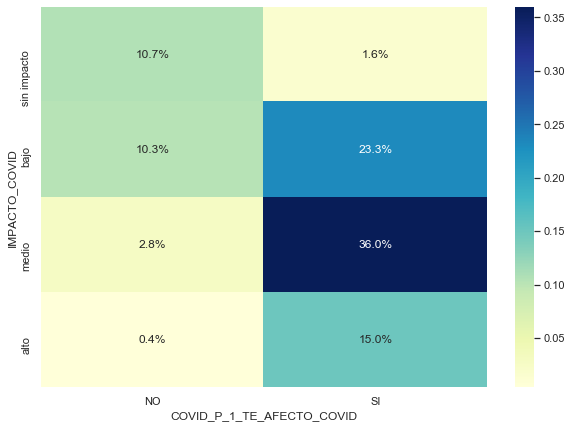

In [73]:
view_cat(conoceme, 'COVID_P_1_TE_AFECTO_COVID', 'IMPACTO_COVID', percent=True)

In [74]:
conoceme['IMPACTO_COVID'].dtype

CategoricalDtype(categories=['sin impacto', 'bajo', 'medio', 'alto'], ordered=False)

#### NOTA: Se considerará con mayor peso la pregunta 13 donde el cliente toma una opción dentro de un rango, pero en consideracipon los casos donde hay controversía con la 1er pregunta

## >> Etiquetas validadas

##### Etiqueta 1

In [75]:
conoceme['COVID_ESTRATEGIA'] = conoceme['COVID_P_14_1'].copy()
conoceme['COVID_ESTRATEGIA'] = conoceme['COVID_ESTRATEGIA'].fillna('Sin categoria')
conoceme['COVID_ESTRATEGIA'] = conoceme['COVID_ESTRATEGIA'].apply(lambda _: _.strip().upper())

conoceme['COVID_ESTRATEGIA'].value_counts(dropna=False) # ESTRATEGIA

MANTENER         386
FEVE              46
CRECER            45
REPROGRAMAR       24
REPERFILAR         2
REFINANCIAR        2
SIN CATEGORIA      1
Name: COVID_ESTRATEGIA, dtype: int64

##### Etiqueta 2

In [76]:
conoceme['COVID_FEVE'] = conoceme['COVID_P_14_2'].copy()
conoceme['COVID_FEVE'] = conoceme['COVID_FEVE'].fillna('Sin categoria')
conoceme['COVID_FEVE'] = conoceme['COVID_FEVE'].apply(lambda _: _.strip().upper())

conoceme['COVID_FEVE'].value_counts(dropna=False) # FEVE

SIN FEVE         286
SEGUIR COVID      85
SEGUIR            75
REDUCIR           25
SIN CATEGORIA     21
GARANTIZAR         9
SALIR              5
Name: COVID_FEVE, dtype: int64

### Ordenamiento de categorias

In [77]:
conoceme['COVID_ESTRATEGIA'] = pd.Categorical(
    conoceme['COVID_ESTRATEGIA'], [
        _.upper() for _ in ["SIN CATEGORIA", "FEVE", "REFINANCIAR", "REPERFILAR", "REPROGRAMAR", "MANTENER",  "CRECER"]
    ]
)

In [78]:
conoceme['COVID_FEVE'] = pd.Categorical(
    conoceme['COVID_FEVE'], [
        _.upper() for _ in ["Salir", "Reducir", "Seguir COVID", "Seguir", "Garantizar", "Sin FEVE"]
    ]
)

In [79]:
from statsmodels.graphics.mosaicplot import mosaic

In [80]:

help(mosaic)

Help on function mosaic in module statsmodels.graphics.mosaicplot:

mosaic(data, index=None, ax=None, horizontal=True, gap=0.005, properties=<function <lambda> at 0x000002576416B948>, labelizer=None, title='', statistic=False, axes_label=True, label_rotation=0.0)
    Create a mosaic plot from a contingency table.
    
    It allows to visualize multivariate categorical data in a rigorous
    and informative way.
    
    Parameters
    ----------
    data : {dict, Series, ndarray, DataFrame}
        The contingency table that contains the data.
        Each category should contain a non-negative number
        with a tuple as index.  It expects that all the combination
        of keys to be represents; if that is not true, will
        automatically consider the missing values as 0.  The order
        of the keys will be the same as the one of insertion.
        If a dict of a Series (or any other dict like object)
        is used, it will take the keys as labels.  If a
        np.ndar

In [81]:
#assert False

AssertionError: 

In [82]:
conoceme.shape

(506, 166)

In [83]:
conoceme['COVID_P_2_2'].value_counts(dropna=False)

2    449
1     57
Name: COVID_P_2_2, dtype: int64

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
mosaic(conoceme, ['PREOCUPA', 'COVID_FEVE'], gap=0, ax=axes, statistic=False, axes_label=False)
#conoceme['COVID_ACOGIO_SUSPENSION_PERFECTA'].value_counts(dropna=False)
conoceme['COVID_ACOGIO_SUSPENSION_PERFECTA'] = conoceme['COVID_P_2_2'].apply(lambda _: 'SI' if str(_).strip() in ('1', '1.0') else 'NO')
#del conoceme['COVID_P_2_2']
conoceme['COVID_ACOGIO_SUSPENSION_PERFECTA'].value_counts()

NameError: name 'axes' is not defined

In [85]:
conoceme['PREOCUPA'].value_counts()

0    388
1    118
Name: PREOCUPA, dtype: int64

In [86]:
conoceme['PREOCUPA_'] = conoceme['PREOCUPA'].apply(lambda _: 'SI' if str(_).strip() == '1' else 'NO')
conoceme['PREOCUPA_'].value_counts()

NO    388
SI    118
Name: PREOCUPA_, dtype: int64

In [87]:
#conoceme['COVID_ACOGIO_SUSPENSION_PERFECTA_'] = conoceme['COVID_ACOGIO_SUSPENSION_PERFECTA'].apply(
#    lambda _: 'SI SE ACOGIO' if _ == 'SI' else 'NO SE ACOGIÓ'
#)
#conoceme['COVID_ACOGIO_SUSPENSION_PERFECTA_'].value_counts()

(<Figure size 1080x504 with 3 Axes>,
 OrderedDict([(('SEGUIR', 'medio'),
               (0.0, 0.0, 0.12371134020618557, 0.46060606060606063)),
              (('SEGUIR', 'alto'),
               (0.0,
                0.4909090909090909,
                0.12371134020618557,
                0.14545454545454536)),
              (('SEGUIR', 'bajo'),
               (0.0,
                0.6666666666666665,
                0.12371134020618557,
                0.23030303030303034)),
              (('SEGUIR', 'sin impacto'),
               (0.0,
                0.9272727272727272,
                0.12371134020618557,
                0.07272727272727268)),
              (('SEGUIR COVID', 'medio'),
               (0.16371134020618555,
                0.0,
                0.1402061855670103,
                0.36363636363636365)),
              (('SEGUIR COVID', 'alto'),
               (0.16371134020618555,
                0.3939393939393939,
                0.1402061855670103,
                0.491

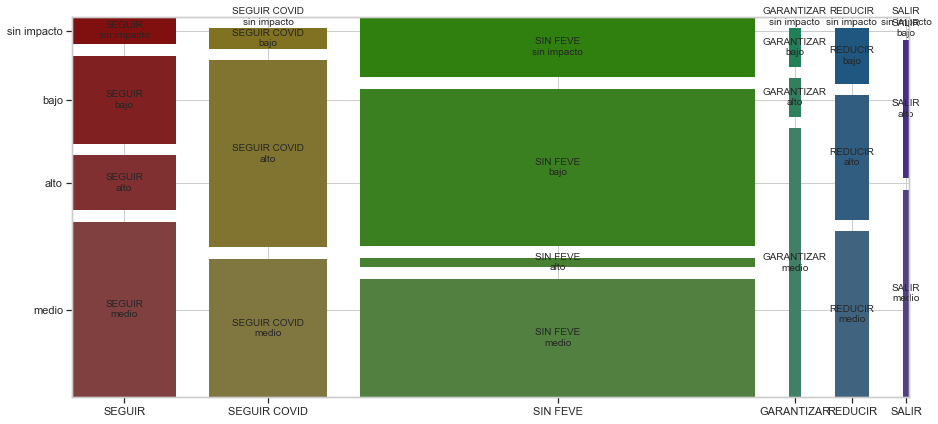

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
mosaic(conoceme, ['COVID_FEVE', 'IMPACTO_COVID'], gap=0.05, ax=axes, statistic=False, axes_label=True)

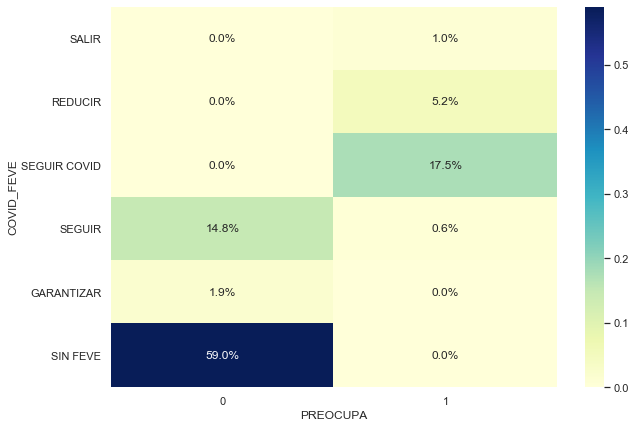

In [89]:
view_cat(conoceme, 'PREOCUPA', 'COVID_FEVE', percent=True)

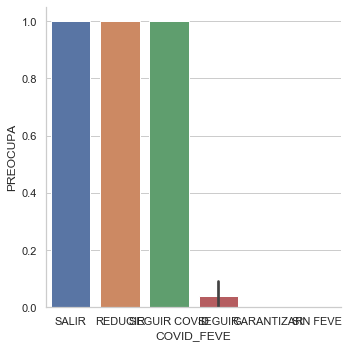

In [90]:
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
sns.catplot(x="COVID_FEVE", y="PREOCUPA", kind="bar", data=conoceme)

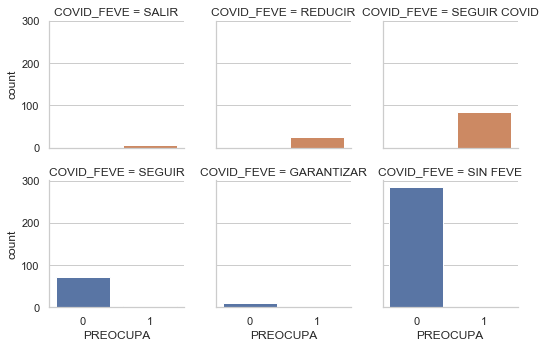

In [91]:
sns.catplot(x="PREOCUPA", col="COVID_FEVE", col_wrap=3,
                data=conoceme, kind="count", height=2.5)

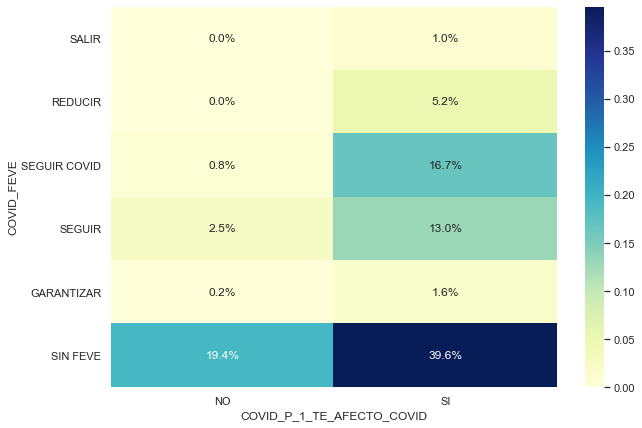

In [92]:
view_cat(conoceme, 'COVID_P_1_TE_AFECTO_COVID', 'COVID_FEVE', percent=True)

##### CRUCE  DE CATGORIAS MANEJADAS ACTUALMENTE

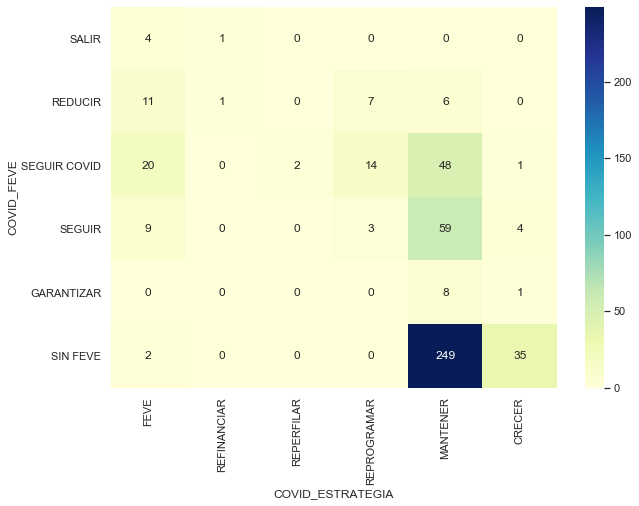

In [93]:
view_cat(conoceme, 'COVID_ESTRATEGIA', 'COVID_FEVE', percent=False)

## >> Validación de importnacia de la pregunta: 2_1 ¿Se encuentra actualmente operando?

In [94]:
conoceme['COVID_P_2_1_ESTA_OPERANDO'] = conoceme['COVID_P_2_1'].copy()
conoceme['COVID_P_2_1_ESTA_OPERANDO'].value_counts(dropna=False)

1    492
2     14
Name: COVID_P_2_1_ESTA_OPERANDO, dtype: int64

#### En porcentaje

In [95]:
conoceme['COVID_P_2_1_ESTA_OPERANDO'].value_counts(dropna=False, normalize=True)

1    0.972332
2    0.027668
Name: COVID_P_2_1_ESTA_OPERANDO, dtype: float64

In [96]:
conoceme['COVID_P_2_1_ESTA_OPERANDO'] = conoceme['COVID_P_2_1_ESTA_OPERANDO'].apply(parser_si_no)

In [97]:
del conoceme['COVID_P_2_1']
conoceme['COVID_P_2_1_ESTA_OPERANDO'].value_counts()

SI    492
NO     14
Name: COVID_P_2_1_ESTA_OPERANDO, dtype: int64

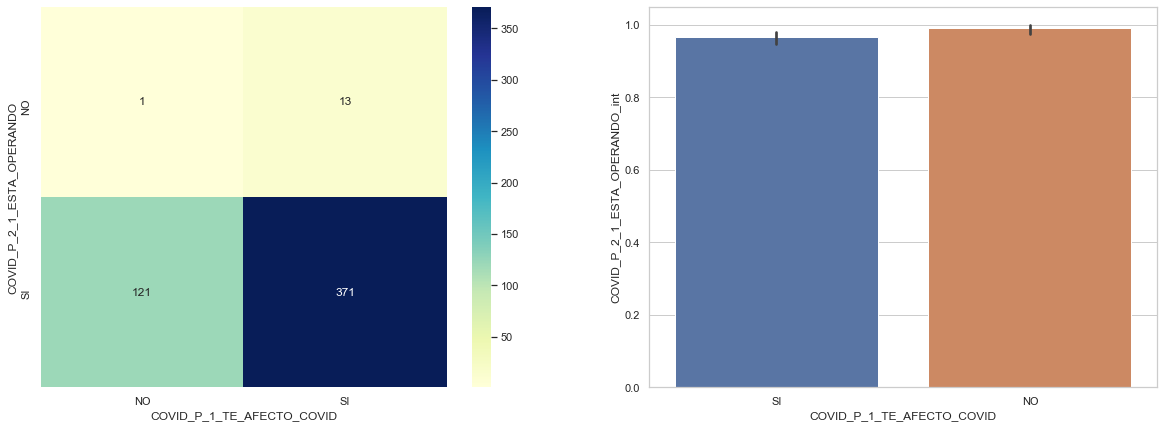

In [98]:
view_cat2(conoceme, 'COVID_P_1_TE_AFECTO_COVID', 'COVID_P_2_1_ESTA_OPERANDO', percent=False)

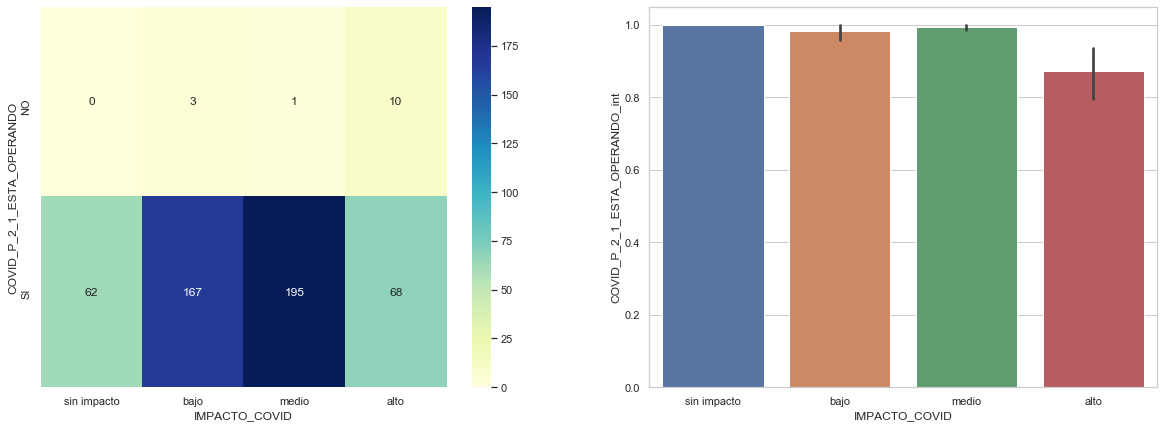

In [99]:
view_cat2(conoceme, 'IMPACTO_COVID','COVID_P_2_1_ESTA_OPERANDO')

#### Cruce con las variables fijas 

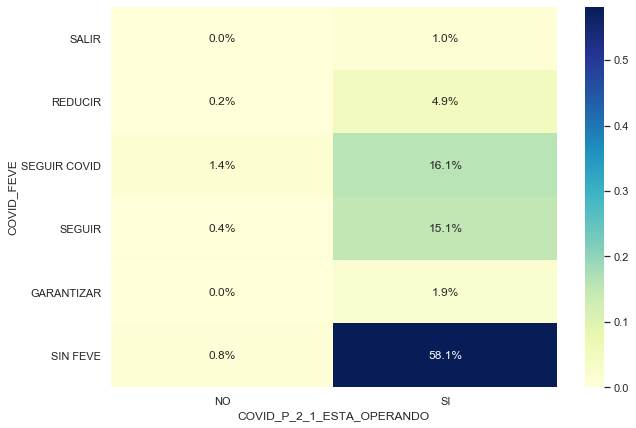

In [100]:
view_cat(conoceme, 'COVID_P_2_1_ESTA_OPERANDO', 'COVID_FEVE', percent= True)

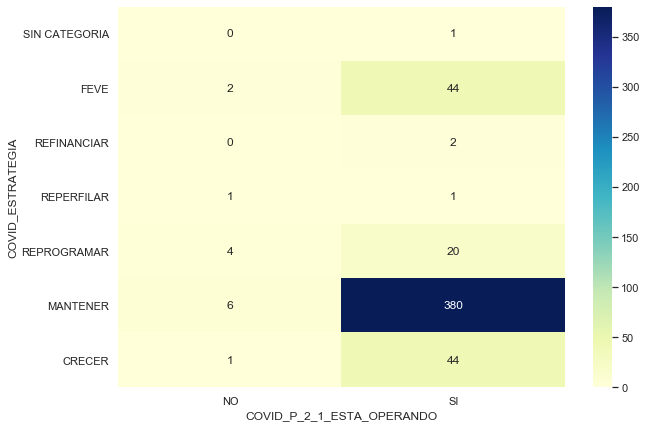

In [101]:
view_cat(conoceme, 'COVID_P_2_1_ESTA_OPERANDO', 'COVID_ESTRATEGIA', percent=False)

## >> Validación de importnacia de la pregunta: 2_3 ¿Redujo el personal?, ¿En que porcentaje?

In [102]:
#covid['PREGUNTA_2_3_2'].dtype

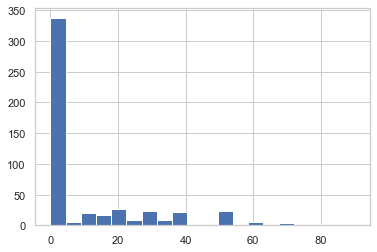

In [103]:
conoceme['COVID_PORCENTAJE_REDUCCION_PERSONAL'] = conoceme['COVID_P_2_3_2'].copy()
conoceme['COVID_PORCENTAJE_REDUCCION_PERSONAL'] = conoceme['COVID_PORCENTAJE_REDUCCION_PERSONAL'].fillna(0.0)
del conoceme['COVID_P_2_3_2']
conoceme['COVID_PORCENTAJE_REDUCCION_PERSONAL'].hist(bins=20)

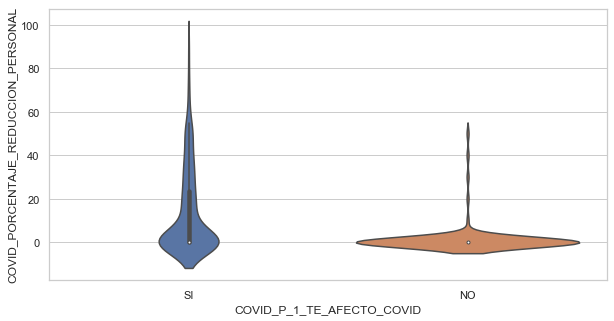

In [104]:
view_numeric(conoceme, 'COVID_PORCENTAJE_REDUCCION_PERSONAL', 'COVID_P_1_TE_AFECTO_COVID')

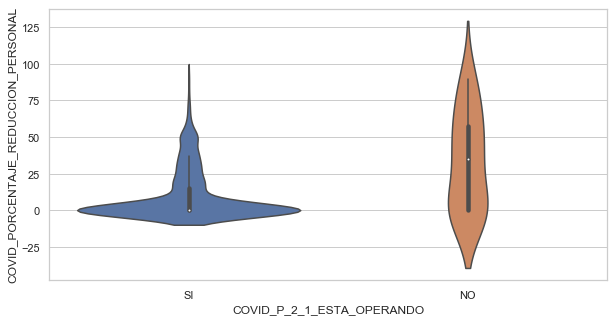

In [105]:
view_numeric(conoceme, 'COVID_PORCENTAJE_REDUCCION_PERSONAL', 'COVID_P_2_1_ESTA_OPERANDO')

In [106]:
print(list(conoceme.columns))

['TIPDOC', 'CODDOC', 'FECHA_ACTUALIZACION_MARKET', 'CODUNICOCLI', 'NOMBRE_COMPLETO', 'DES_GRUPO_ECONOMICO', 'RIESGO', 'ENCARGADO', 'NOMBRE_JEFE', 'ESTADO', 'BUCKET', 'PREOCUPA', 'REGISTRO_x', 'FECHA_LLENADO', 'USUARIO_NOTIFICADO', 'REVISION_USUARIO', 'FECHA_APROBACION', 'IMPACTO', 'PLAN_PROPUESTO', 'MONTO_CRECER', 'DETALLE_CRECER', 'FEVE', 'BLINDAJE', 'MESES_BLINDAJE', 'COMENTARIOS', 'COMENTARIO_ROL_VALIDADOR', 'FUNNEL_1', 'FUNNEL_2', 'FUNNEL_3', 'FUNNEL_4', 'FLG_VIGENTE', 'FLG_SUSPENDIDO', 'FLG_VENCIDA', 'FLG_CANCELADO', 'FLG_MONOLINEA', 'FLG_SOLO_REACTIVA', 'FLG_POSICION', 'CLASIFICACION_LIST_360', 'COD_UNICO_x', 'ACTIVIDAD', 'SUBSECTOR', 'BACKLOG', 'MODELO_NEGOCIO', 'VENTAJA_COMPETITIVA', 'FORTALEZAS_RIESGOS', 'INTEGRACION_VERTICAL', 'GESTION_COMPRAS', 'REGISTRO_y', 'GERENTE_GENERAL', 'GERENTE_FINANCIERO_TIPO', 'GERENTE_FINANCIERO_NOMBRE', 'TIPO_CONTABILIDAD', 'MONTO_LINEA_PROVEEDORES', 'ACTIVO_LIBRE_GRAVAMEN', 'PROYECCION_INVERSION', 'PROYECCION_VENTAS', 'FECHA_ACTUALIZACION', 'PRO

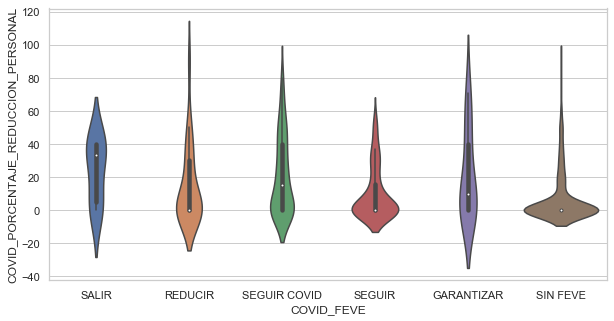

In [107]:
view_numeric(conoceme, 'COVID_PORCENTAJE_REDUCCION_PERSONAL', 'COVID_FEVE')

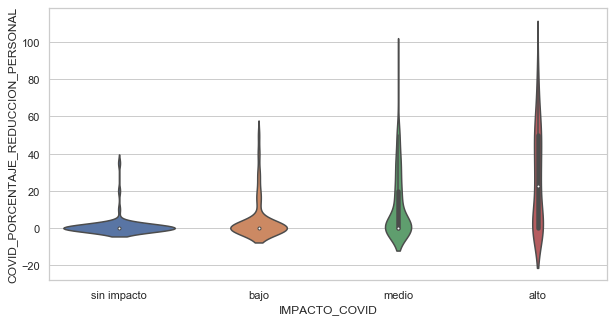

In [108]:
view_numeric(conoceme, 'COVID_PORCENTAJE_REDUCCION_PERSONAL', 'IMPACTO_COVID')

In [109]:
conoceme['PREOCUPA_'] = conoceme['PREOCUPA'].apply(parser_si_no)
conoceme['PREOCUPA_'] .value_counts()

NO    388
SI    118
Name: PREOCUPA_, dtype: int64

In [110]:
conoceme['PREOCUPA_'] = conoceme['PREOCUPA'].apply(parser_si_no)
conoceme['PREOCUPA_'] .value_counts()

NO    388
SI    118
Name: PREOCUPA_, dtype: int64

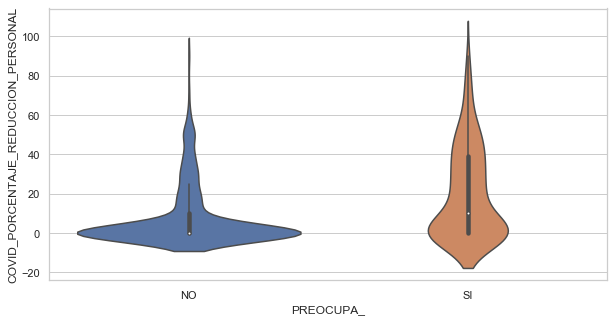

In [111]:
view_numeric(conoceme, 'COVID_PORCENTAJE_REDUCCION_PERSONAL', 'PREOCUPA_')

In [112]:
#m

In [113]:
conoceme['OPERANDO_SUSPENSION'] = conoceme['COVID_P_2_1_ESTA_OPERANDO'].astype(str) + '_' + conoceme['COVID_ACOGIO_SUSPENSION_PERFECTA'].astype(str)
conoceme['OPERANDO_SUSPENSION'].value_counts(dropna=False)

KeyError: 'COVID_ACOGIO_SUSPENSION_PERFECTA'

## COMBINACION  (SIGUES_OPERANDO) _ (SUSPENSION_LABORES)   VS   PORCENTAJE DE REDUCCION DE PERSONAL

ValueError: Could not interpret input 'OPERANDO_SUSPENSION'

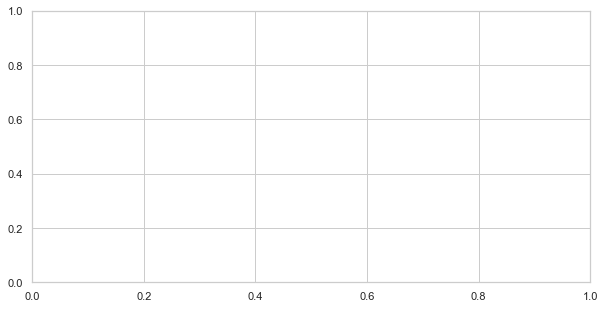

In [120]:
view_numeric(conoceme, 'COVID_PORCENTAJE_REDUCCION_PERSONAL', 'OPERANDO_SUSPENSION')

KeyError: 'OPERANDO_SUSPENSION'

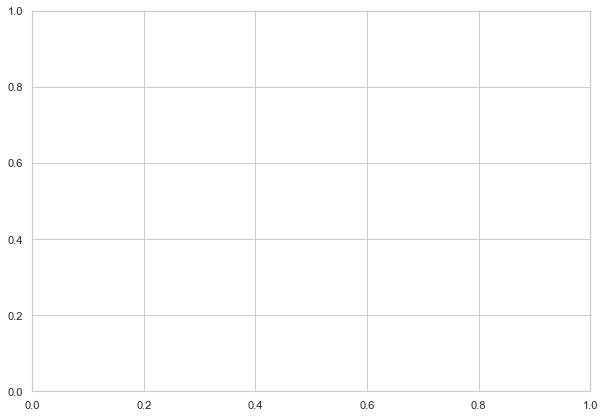

In [121]:
view_cat(conoceme, 'IMPACTO_COVID', 'OPERANDO_SUSPENSION')

In [ ]:
view_cat(conoceme, 'COVID_FEVE', 'OPERANDO_SUSPENSION')

KeyError: 'OPERANDO_SUSPENSION'

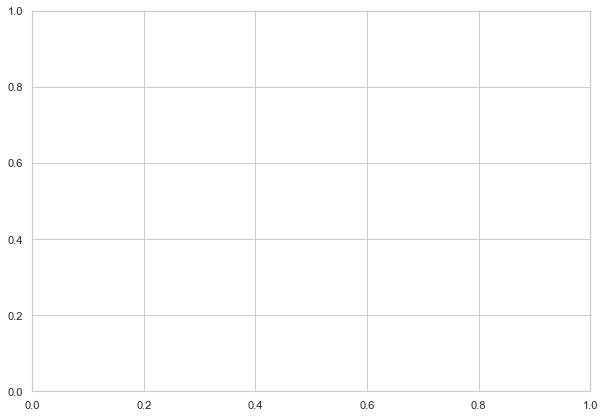

In [122]:
view_cat(conoceme, 'COVID_ESTRATEGIA', 'OPERANDO_SUSPENSION')

## >> Validación de importnacia de la pregunta: 4 ¿En qué porcentaje se ha reducido su ingreso mensual en lo que va del 2020?

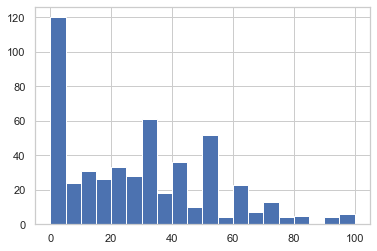

In [123]:
conoceme['COVID_PORCENTAJE_REDUCCION_INGREO_MENUSAL'] = conoceme['COVID_P_4'].fillna(0.0)

del conoceme['COVID_P_4']
conoceme['COVID_PORCENTAJE_REDUCCION_INGREO_MENUSAL'].hist(bins=20)

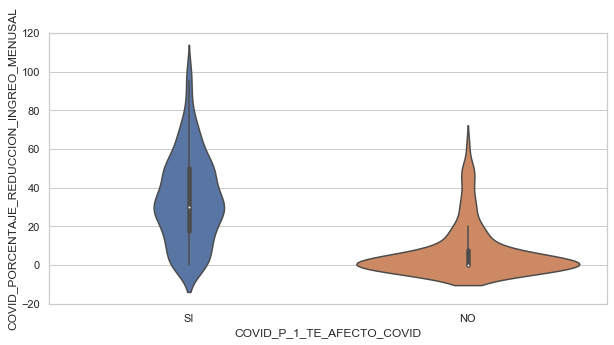

In [124]:
view_numeric(conoceme, 'COVID_PORCENTAJE_REDUCCION_INGREO_MENUSAL', 'COVID_P_1_TE_AFECTO_COVID')

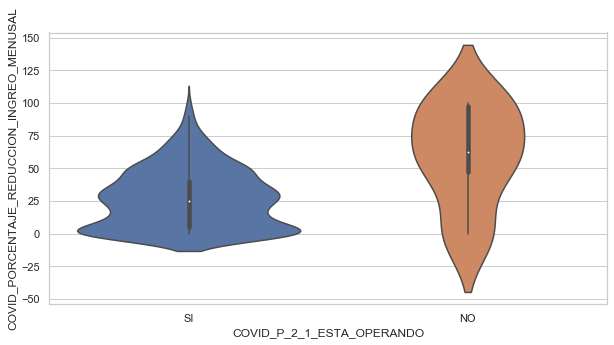

In [125]:
view_numeric(conoceme, 'COVID_PORCENTAJE_REDUCCION_INGREO_MENUSAL', 'COVID_P_2_1_ESTA_OPERANDO')

ValueError: Could not interpret input 'OPERANDO_SUSPENSION'

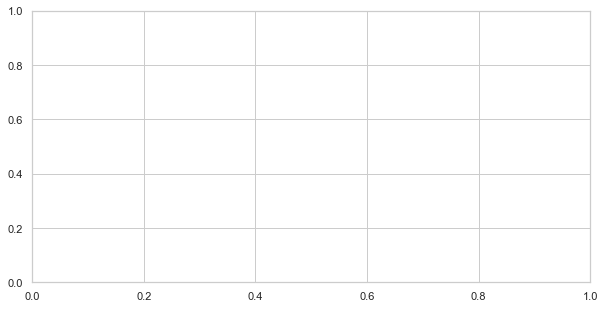

In [126]:
view_numeric(conoceme, 'COVID_PORCENTAJE_REDUCCION_INGREO_MENUSAL', 'OPERANDO_SUSPENSION')

In [127]:
#view_numeric(conoceme, 'COVID_P_4_PORCENTAJE_REDUCCION_INGREO_MENUSAL', 'ESTA_OPERANDO')

KeyError: 'OPERANDO_SUSPENSION'

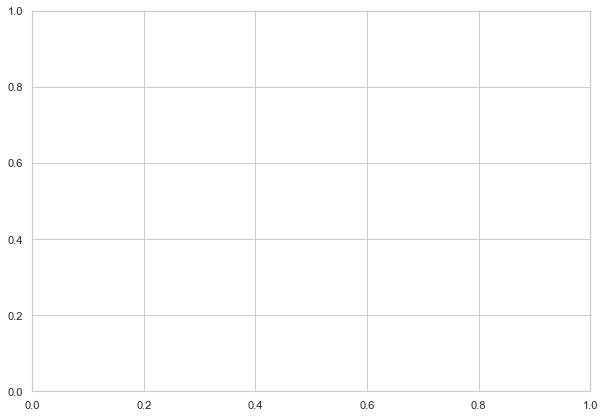

In [128]:
conoceme['COVID_REACTIVA_SF_NO_IBK'] = conoceme['COVID_P_11'].apply(parser_si_no)

del conoceme['COVID_P_11']
view_cat(conoceme, 'COVID_REACTIVA_SF_NO_IBK', 'OPERANDO_SUSPENSION')

In [129]:
listado = ['COVID_P_11_1_1', 'COVID_P_11_1_2', 'COVID_P_11_2_1', 'COVID_P_11_2_2', 'COVID_P_11_3_1', 'COVID_P_11_3_2',
           'COVID_P_11_4_1', 'COVID_P_11_4_2', 'COVID_P_11_5_1', 'COVID_P_11_5_2', 'COVID_P_11_6_1', 'COVID_P_11_6_2']

for col in listado:
    print(col, conoceme[col].dtype)
    if col.endswith('_2'):
        print(col)
        conoceme[col] = conoceme[col].fillna(0)

COVID_P_11_1_1 object
COVID_P_11_1_2 float64
COVID_P_11_1_2
COVID_P_11_2_1 object
COVID_P_11_2_2 float64
COVID_P_11_2_2
COVID_P_11_3_1 object
COVID_P_11_3_2 float64
COVID_P_11_3_2
COVID_P_11_4_1 object
COVID_P_11_4_2 float64
COVID_P_11_4_2
COVID_P_11_5_1 object
COVID_P_11_5_2 float64
COVID_P_11_5_2
COVID_P_11_6_1 object
COVID_P_11_6_2 float64
COVID_P_11_6_2


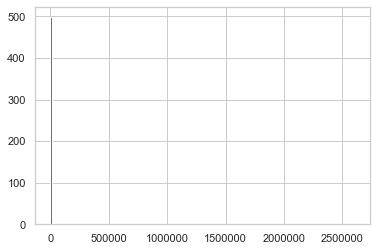

In [130]:
conoceme['COVID_SUMA_REACTIVA_SF_NO_IBK'] = conoceme[[col for col in listado if col.endswith('_2')]].sum(axis=1)
conoceme['COVID_SUMA_REACTIVA_SF_NO_IBK'].hist(bins=200)

ValueError: Could not interpret input 'OPERANDO_SUSPENSION'

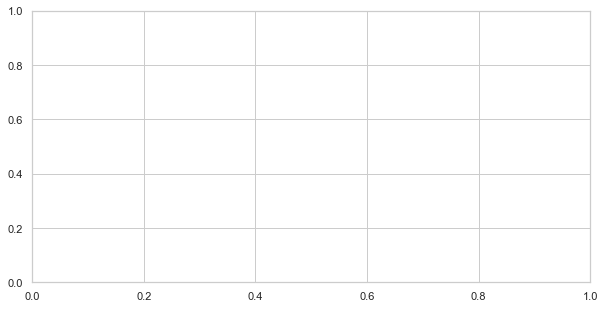

In [131]:
view_numeric(conoceme, 'COVID_SUMA_REACTIVA_SF_NO_IBK', 'OPERANDO_SUSPENSION')

KeyError: 'COVID_ACOGIO_SUSPENSION_PERFECTA'

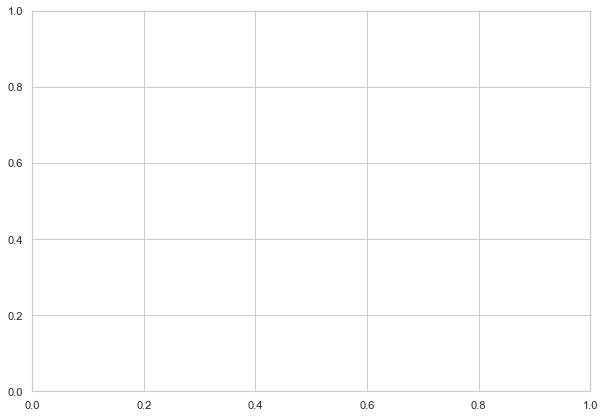

In [132]:
view_cat(conoceme, 'COVID_P_1_TE_AFECTO_COVID', 'COVID_ACOGIO_SUSPENSION_PERFECTA', percent=False)

#### RECAPITULANDO LO QUE SE TIENE HASTA EL MOMENTO

In [133]:
conoceme['IBK_R2_MONTO_PRESTAMO_REACTIVA_1'] = conoceme['IBK_R2_MONTO_PRESTAMO_REACTIVA_1'].fillna(0)
conoceme['IBK_R2_MONTO_PRESTAMO_REACTIVA_2'] = conoceme['IBK_R2_MONTO_PRESTAMO_REACTIVA_2'].fillna(0)
conoceme['COVID_SUMA_REACTIVA_SF_NO_IBK'] = conoceme['COVID_SUMA_REACTIVA_SF_NO_IBK'].fillna(0)
conoceme['COVID_SUMA_REACTIVA_SF_NO_IBK'] = conoceme['COVID_SUMA_REACTIVA_SF_NO_IBK'].apply(lambda _: _*3.5)

KeyError: 'IBK_R2_MONTO_PRESTAMO_REACTIVA_1'

In [134]:
conoceme[conoceme['COVID_SUMA_REACTIVA_SF_NO_IBK'] > 0].head()

,TIPDOC,CODDOC,FECHA_ACTUALIZACION_MARKET,CODUNICOCLI,NOMBRE_COMPLETO,DES_GRUPO_ECONOMICO,RIESGO,ENCARGADO,NOMBRE_JEFE,ESTADO,...,COVID_P_1_TE_AFECTO_COVID,COVID_ESTRATEGIA,COVID_FEVE,PREOCUPA_,COVID_P_2_1_ESTA_OPERANDO,COVID_P_2_1_ESTA_OPERANDO_int,COVID_PORCENTAJE_REDUCCION_PERSONAL,COVID_PORCENTAJE_REDUCCION_INGREO_MENUSAL,COVID_REACTIVA_SF_NO_IBK,COVID_SUMA_REACTIVA_SF_NO_IBK
2,2,20493091396,2020-10-27 13:00:56.210,0013957817,GASOCENTRO PUENTE NUEVO,IBAÑEZ MANCHEGO,81743.356286,RAQUEL IRENE CORDOVA ZAMORA,JAVIER GONZALES VELARDE,VALIDADO,...,SI,MANTENER,SEGUIR COVID,SI,SI,1,0.0,50.0,SI,750.0
4,2,20514364665,2020-10-27 13:00:56.210,0011865755,DISTRIMAX,CANTOL,206593.802857,ELIZABETH LISSET FOX MEDINA,MIRANDA ZAMBRANO JORGE ALFREDO,VALIDADO,...,NO,MANTENER,SIN FEVE,NO,SI,1,0.0,25.0,SI,1080.0
7,2,20506626910,2020-10-27 13:00:56.210,0011038047,PICORP,PICORP,36916.631429,MARQUINA MOTTA MAURICIO,JAVIER GONZALES VELARDE,VALIDADO,...,SI,MANTENER,SIN FEVE,NO,SI,1,40.0,67.0,SI,600.0
9,2,20509946605,2020-10-27 13:00:56.210,0012645311,NEGOCIACIONES PERUANITA,NEGOGROUP,354648.420000,JOSE CARLOS ROMERO,JAVIER GONZALES VELARDE,VALIDADO,...,NO,CRECER,SIN FEVE,NO,SI,1,0.0,0.0,SI,3140.0
12,2,20471203816,2020-10-27 13:00:56.210,0011038268,JEVARO,JEVARO,65098.136029,BACIGALUPO FALLAQUE ANA LUCIA,JAVIER GONZALES VELARDE,VALIDADO,...,SI,CRECER,SIN FEVE,NO,SI,1,50.0,30.0,SI,900.0


In [135]:
conoceme['COVID_SUMA_REACTIVA_IBK'] =  conoceme['IBK_R2_MONTO_PRESTAMO_REACTIVA_1'] + conoceme['IBK_R2_MONTO_PRESTAMO_REACTIVA_2']

KeyError: 'IBK_R2_MONTO_PRESTAMO_REACTIVA_1'

In [136]:
conoceme['IBK_R2_TOTAL_REACTIVA_SF'] = conoceme['COVID_SUMA_REACTIVA_SF_NO_IBK'] + conoceme['COVID_SUMA_REACTIVA_IBK']

KeyError: 'COVID_SUMA_REACTIVA_IBK'

In [137]:
conoceme['IBK_R2_TOTAL_REACTIVA_SF'].hist(bins=100)

KeyError: 'IBK_R2_TOTAL_REACTIVA_SF'

ValueError: Could not interpret input 'OPERANDO_SUSPENSION'

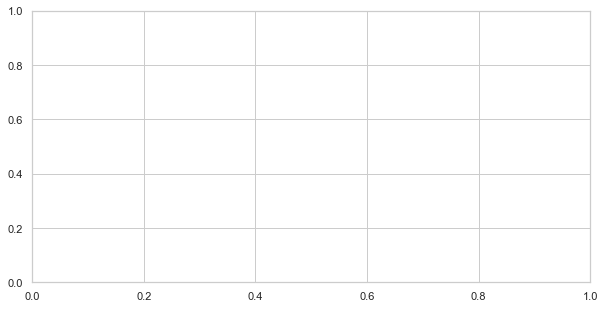

In [138]:
view_numeric(conoceme, 'IBK_R2_TOTAL_REACTIVA_SF', 'OPERANDO_SUSPENSION')

#### Reactiva de CLientes NO estan operando y SI se ha acatado a la suspensión de labores

In [139]:
conoceme[conoceme['OPERANDO_SUSPENSION'] == 'NO_SI'].shape[0]

KeyError: 'OPERANDO_SUSPENSION'

In [140]:
conoceme[conoceme['OPERANDO_SUSPENSION'] == 'NO_SI']['IBK_R2_TOTAL_REACTIVA_SF'].hist()

KeyError: 'OPERANDO_SUSPENSION'

In [141]:
#view_numeric(conoceme[conoceme['OPERANDO_SUSPENSION'] == 'NO_SI'], 'IBK_R2_TOTAL_REACTIVA_SF', 'OPERANDO_SUSPENSION')

#### Reactiva de CLientes NO estan operando y NO se ha acatado a la suspensión de labores

In [142]:
conoceme[conoceme['OPERANDO_SUSPENSION'] == 'NO_NO']['IBK_R2_TOTAL_REACTIVA_SF'].hist()

KeyError: 'OPERANDO_SUSPENSION'

In [143]:
#df = df.groupby("date").agg({"duration": np.sum, "user_id": pd.Series.nunique})
#df

### REACTIVA RCC

In [144]:
query_reeactiva_rcc = """
    SELECT * FROM STG.HD_VMVP_REACTIVA_ALERTAS_CARTERA_BE ORDER BY COD_UNICO DESC
"""
#reactiva_rcc = pd.read_sql(
#   query_reeactiva_rcc , connection_market
#)
#reactiva_rcc.head(2)

In [145]:
#reactiva_rcc.groupby(by=['DES_CREDITO']).size()

In [146]:
#reactiva_rcc[reactiva_rcc['DES_CREDITO'] == 'CREDITOS A MEDIANAS EMPRESAS'].shape, reactiva_rcc.shape

In [147]:
#info_reactiva = reactiva_rcc.groupby(by=['COD_UNICO']).agg({'COD_EMPRESA': pd.Series.nunique, 'NUM_DOC': 'count'})
#info_reactiva.head()

In [148]:
#info_reactiva[info_reactiva['NUM_DOC'] > 2]

### REACTIVA IBK AGAIN

In [149]:
query_reactiva_ibk = """
SELECT DISTINCT(A.CODUNICOCLI)
FROM 
ODS.MD_DESEMBOLSO_REACTIVA A WITH (NOLOCK)
INNER JOIN
ODS.HD_ENVIO_COFIDE_V B WITH (NOLOCK)
on A.CODUNICOCLI = B.CODUNICOCLI and A.NRO_CREDITO = B.NRO_CREDITO
WHERE 1 = 1
and B.ESTADO = 'ENVIADO'
--and CERTIFICADO like 'CGAR2-%'
--ORDER BY B.RAZON_SOCIAL DESC
"""

#reactiva_ibk = pd.read_sql(
#   query_reactiva_ibk , connection_market
#)
#reactiva_ibk.head(2)

In [150]:
#reactiva_ibk.shape

In [151]:
#reactiva_ibk.head()

In [152]:
conoceme.shape

(506, 169)

In [153]:
conoceme.to_excel('CONSOLIDADO_FICHAS_20201027.xlsx', index=False)
conoceme.to_csv('CONSOLIDADO_FICHAS_20201027.csv', index=False)

In [ ]:
conoceme